In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [82]:
## Load amygdala database
df = pd.read_csv('FCallSessions.csv')
# create a long format for analysis
df.describe()

,groupIdx,amg_hippPost1,amg_vmPFC1,amg_HippAnt1,amg_vmPFCAnt1,hippAnt_vmPFCAnt1,hippAnt_hippPost1,amg_hippPost2,amg_vmPFC2,amg_hippAnt2,...,amg_hippAnt3,amg_vmPFCAnt3,hippAnt_vmPFCAnt3,hippAnt_hippPost3,amg_hippPost4,amg_vmPFC4,amg_hippAnt4,amg_vmPFCAnt4,hippAnt_vmPFCAnt4,hippAnt_hippPost4
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,25.000000,25.000000,25.000000,...,22.000000,22.000000,22.000000,22.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,0.500000,0.271148,0.513186,0.271258,0.349830,0.217479,0.304504,0.296642,0.364202,0.316405,...,0.271146,0.214985,0.178116,0.425026,0.162026,0.363819,0.248858,0.314005,0.076422,0.335956
std,0.509902,0.198495,0.226282,0.263443,0.222321,0.301799,0.256845,0.297025,0.219025,0.240962,...,0.267546,0.292768,0.299988,0.193779,0.342823,0.319029,0.231000,0.255233,0.252961,0.205687
min,0.000000,-0.096844,-0.055699,-0.192782,-0.349564,-0.469990,-0.250251,-0.254465,-0.272251,-0.214743,...,-0.189834,-0.385748,-0.460460,-0.029337,-0.479055,-0.142419,-0.115037,-0.061807,-0.324347,-0.133583
25%,0.000000,0.121527,0.351217,0.139287,0.257461,0.093451,0.171554,0.073380,0.239052,0.097621,...,0.094045,0.066558,0.014552,0.289250,-0.116818,0.060517,0.029720,0.115222,-0.108495,0.250125
50%,0.500000,0.272865,0.577810,0.263428,0.385805,0.238740,0.317298,0.380831,0.365332,0.382710,...,0.301530,0.249703,0.176067,0.489939,0.239219,0.392061,0.295949,0.388116,0.028039,0.359252
75%,1.000000,0.420370,0.673977,0.393543,0.477417,0.406410,0.540128,0.553591,0.488261,0.502424,...,0.448451,0.413853,0.458328,0.550105,0.397470,0.665525,0.429344,0.505272,0.281719,0.422300
max,1.000000,0.606122,0.774370,0.750596,0.646947,0.662831,0.648514,0.698112,0.675950,0.733511,...,0.751112,0.740254,0.662622,0.694430,0.641858,0.748723,0.638357,0.760333,0.527674,0.643018


## Amygdala Hippocampus

In [22]:
#vars = ['amg_HippAnt1', 'amg_hippAnt2', 'amg_hippAnt3', 'amg_hippAnt4']
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_hippPost1','amg_hippPost2',
                                                                         'amg_hippPost3'])

In [23]:
df_long.groupby(['groupIdx', 'variable']).describe()

value                                          \
                       count      mean       std       min       25%   
groupIdx variable                                                      
0        amg_hippPost1  13.0  0.232713  0.156011  0.005189  0.108381   
         amg_hippPost2  12.0  0.438861  0.180178  0.073380  0.381203   
         amg_hippPost3  10.0  0.292109  0.357691 -0.366046  0.101157   
1        amg_hippPost1  13.0  0.309582  0.233546 -0.096844  0.160964   
         amg_hippPost2  13.0  0.165363  0.328317 -0.254465 -0.128545   
         amg_hippPost3  12.0  0.376429  0.265625 -0.131075  0.229355   

                                                      
                             50%       75%       max  
groupIdx variable                                     
0        amg_hippPost1  0.234275  0.332985  0.494981  
         amg_hippPost2  0.472924  0.578617  0.633108  
         amg_hippPost3  0.229846  0.567329  0.788340  
1        amg_hippPost1  0.302873  0.486021  0.606122  
         amg_hippPost2  0.124015  0.380831  0.698112  
         amg_hippPost3  0.396978  0.505380  0.807860

In [24]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        value   
No. Observations:          73             Method:                    REML    
No. Groups:                26             Scale:                     0.0601  
Min. group size:           2              Log-Likelihood:            -11.8762
Max. group size:           3              Converged:                 Yes     
Mean group size:           2.8                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                           0.233    0.072  3.230 0.001  0.092  0.374
variable[T.amg_hippPost2]           0.203    0.098  2.065 0.039  0.010  0.396
variable[T.amg_hippPost3]           0.058    0.104  0.562 0.574 -0.145  0.262
groupI

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [25]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.042      1     19  0.042  0.452    0.509  0.023  nan
variable     0.052      2     38  0.026  0.421    0.660  0.022    0.971
Interaction  0.263      2     38  0.132  2.146    0.131  0.101  nan



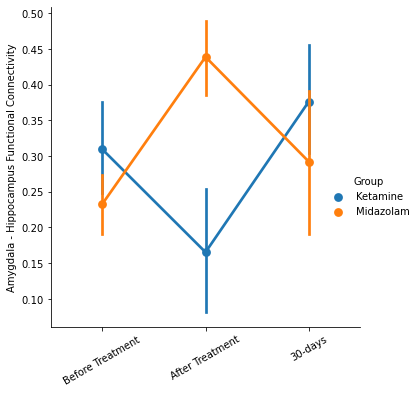

In [28]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - Hippocampus Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_postHipp_FC.png', dpi=300, bbox_inches='tight')

In [46]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values 
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_hippPost1','amg_hippPost2','amg_hippPost3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [47]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)
   
    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX]

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=4000, tune=2000, target_accept=0.9, return_inferencedata=False)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

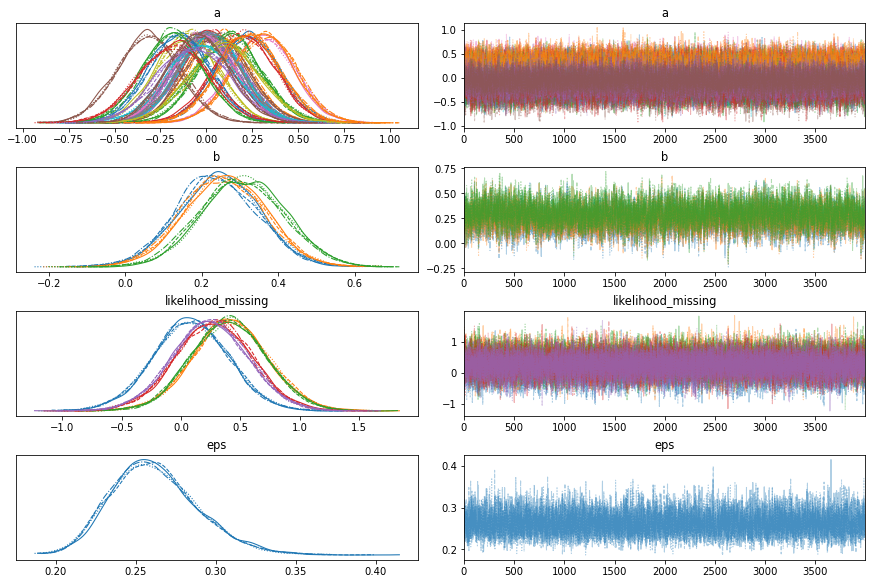

In [48]:
az.plot_trace(trace)

In [49]:
az.summary(trace, hdi_prob=.9)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.013,0.172,-0.295,0.272,0.002,0.001,6921.0,9930.0,1.0
a[1],0.065,0.169,-0.227,0.330,0.002,0.001,7240.0,9766.0,1.0
a[2],0.109,0.195,-0.218,0.422,0.002,0.001,9198.0,10811.0,1.0
a[3],0.020,0.170,-0.250,0.309,0.002,0.001,6998.0,9841.0,1.0
a[4],0.029,0.170,-0.258,0.302,0.002,0.001,7464.0,10478.0,1.0
a[5],0.056,0.171,-0.229,0.331,0.002,0.001,7381.0,9577.0,1.0
a[6],0.305,0.170,0.031,0.585,0.002,0.001,6904.0,9413.0,1.0
a[7],-0.018,0.171,-0.290,0.270,0.002,0.001,7087.0,10285.0,1.0
a[8],-0.106,0.172,-0.378,0.186,0.002,0.001,6945.0,9628.0,1.0
a[9],0.022,0.171,-0.265,0.294,0.002,0.001,7252.0,9203.0,1.0


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.5929375


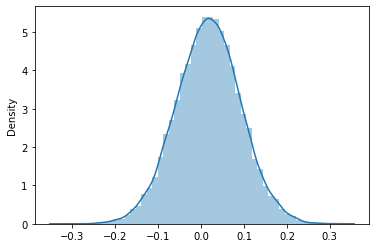

In [52]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.8051875


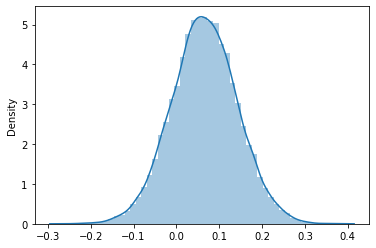

In [53]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [16]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.233,0.060,0.135,0.331,0.002,0.001,1498.0,1983.0,1.0
groupIdx,0.077,0.083,-0.059,0.210,0.002,0.002,1491.0,2046.0,1.0
sd,0.210,0.033,0.159,0.264,0.001,0.001,2003.0,1879.0,1.0


In [17]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.440,0.081,0.300,0.567,0.002,0.001,1984.0,2183.0,1.0
groupIdx,-0.274,0.114,-0.459,-0.090,0.003,0.002,2084.0,2331.0,1.0
sd,0.283,0.045,0.210,0.349,0.001,0.001,2244.0,2041.0,1.0


In [18]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_hippPost3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.295,0.110,0.113,0.466,0.003,0.002,1735.0,2041.0,1.0
groupIdx,0.081,0.150,-0.169,0.314,0.004,0.003,1727.0,2030.0,1.0
sd,0.331,0.059,0.241,0.421,0.001,0.001,2038.0,1819.0,1.0


- Between amygdala and posterior hippocampus there's a difference only after treatment. With Ketamine shows lower connectivity, compared to midazolam.

## Amygdala and vmPFC

In [83]:
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['amg_vmPFC1','amg_vmPFC2',
                                                                         'amg_vmPFC3'])

In [79]:
df_long.groupby(['variable','groupIdx']).describe()

value                                                    \
                    count      mean       std       min       25%       50%   
variable   groupIdx                                                           
amg_vmPFC1 0         13.0  0.476762  0.232118 -0.055699  0.342115  0.523917   
           1         13.0  0.549611  0.223429 -0.009363  0.565582  0.620574   
amg_vmPFC2 0         12.0  0.319887  0.228887 -0.272251  0.231635  0.344384   
           1         13.0  0.405109  0.210103  0.004965  0.310339  0.381881   
amg_vmPFC3 0         10.0  0.486395  0.153387  0.196863  0.432737  0.483726   
           1         12.0  0.344969  0.250293 -0.146157  0.263921  0.324898   

                                         
                          75%       max  
variable   groupIdx                      
amg_vmPFC1 0         0.631171  0.774370  
           1         0.677530  0.766076  
amg_vmPFC2 0         0.472607  0.615081  
           1         0.575514  0.675950  
amg_vmPFC3 0         0.568808  0.753866  
           1         0.526263  0.709229

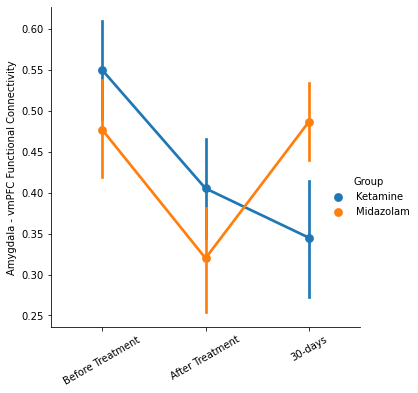

In [65]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point',
           ci=68, hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Amygdala - vmPFC Functional Connectivity")
g._legend.set_title("Group")
new_labels = ['Ketamine','Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('amg_vmpfc_FC.png', dpi=300, bbox_inches='tight')

In [66]:
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.018      1     19  0.018  0.406    0.531  0.021  nan
variable     0.436      2     38  0.218  4.436    0.019  0.189    0.984
Interaction  0.140      2     38  0.070  1.419    0.254  0.070  nan



In [67]:
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                  Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        value  
No. Observations:        73             Method:                    REML   
No. Groups:              26             Scale:                     0.0483 
Min. group size:         2              Log-Likelihood:            -1.2050
Max. group size:         3              Converged:                 Yes    
Mean group size:         2.8                                              
--------------------------------------------------------------------------
                                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------
Intercept                        0.477    0.061  7.802 0.000  0.357  0.597
variable[T.amg_vmPFC2]          -0.157    0.088 -1.782 0.075 -0.330  0.016
variable[T.amg_vmPFC3]           0.009    0.093  0.101 0.919 -0.172  0.191
groupIdx                         0.073    0.

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [68]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [33]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.5, shape=3)

    # Model error
    eps = pm.HalfCauchy('eps', 3)

    y_hat = a[sub_idx] + b[timeIDX] 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(draws=8000, tune=2000, target_accept=0.9, return_inferencedata=False)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/pymc3/model.py:1755: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 8_000 draw iterations (8_000 + 32_000 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'bMed'}>,
        <AxesSubplot:title={'center':'bMed'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

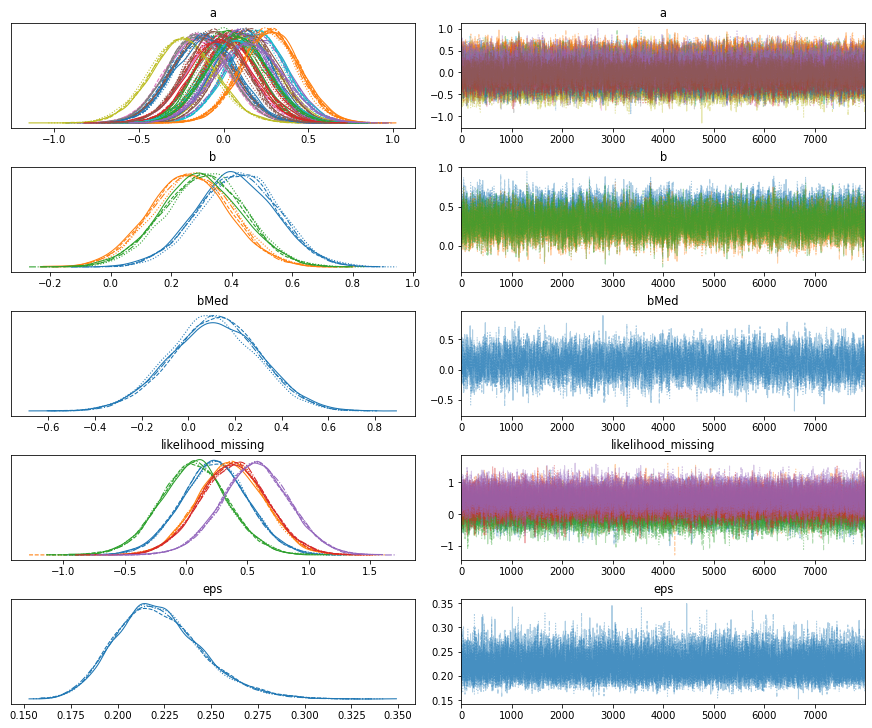

In [26]:
az.plot_trace(trace)

In [34]:
az.summary(trace, hdi_prob=.9)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.070,0.153,-0.315,0.189,0.001,0.001,10527.0,18116.0,1.0
a[1],0.132,0.154,-0.123,0.382,0.001,0.001,11392.0,18314.0,1.0
a[2],0.018,0.175,-0.276,0.303,0.002,0.001,13020.0,20382.0,1.0
a[3],0.020,0.155,-0.235,0.274,0.001,0.001,11128.0,17894.0,1.0
a[4],0.256,0.155,0.003,0.509,0.001,0.001,11206.0,18450.0,1.0
a[5],-0.061,0.154,-0.307,0.198,0.001,0.001,11190.0,18708.0,1.0
a[6],0.031,0.153,-0.219,0.284,0.001,0.001,10975.0,18485.0,1.0
a[7],0.080,0.154,-0.173,0.333,0.001,0.001,11364.0,18365.0,1.0
a[8],0.196,0.153,-0.063,0.440,0.001,0.001,11624.0,17610.0,1.0
a[9],0.148,0.155,-0.108,0.398,0.001,0.001,11791.0,19713.0,1.0


/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.00665625


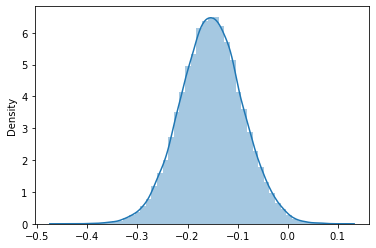

In [35]:
diff = trace['b'][:,1] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.043125


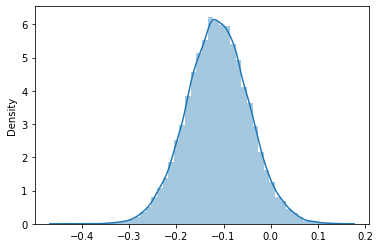

In [37]:
diff = trace['b'][:,2] - trace['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

Differences between groups

In [28]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.481,0.064,0.375,0.584,0.001,0.001,2038.0,2097.0,1.0
groupIdx,0.069,0.092,-0.075,0.222,0.002,0.002,2050.0,2177.0,1.0
sd,0.240,0.039,0.186,0.303,0.001,0.001,2161.0,1968.0,1.0


In [29]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.320,0.068,0.208,0.430,0.002,0.001,1502.0,1827.0,1.0
groupIdx,0.084,0.096,-0.078,0.233,0.002,0.002,1584.0,1983.0,1.0
sd,0.231,0.036,0.174,0.286,0.001,0.001,2333.0,2225.0,1.0


In [30]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('amg_vmPFC3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.484,0.075,0.358,0.601,0.002,0.001,1681.0,1767.0,1.0
groupIdx,-0.140,0.101,-0.306,0.025,0.002,0.002,1782.0,1891.0,1.0
sd,0.226,0.039,0.164,0.285,0.001,0.001,1742.0,1653.0,1.0


- Adding testing of declind within group and between time periods

In [84]:
# Just midazolam
df_longM = df_long[df_long.groupIdx==0]
glm = smf.mixedlm('value ~ variable', data=df_longM, groups = df_longM.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     value 
No. Observations:      35          Method:                 REML  
No. Groups:            13          Scale:                  0.0418
Min. group size:       2           Log-Likelihood:         0.6520
Max. group size:       3           Converged:              Yes   
Mean group size:       2.7                                       
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.477    0.059  8.117 0.000  0.362  0.592
variable[T.amg_vmPFC2] -0.159    0.082 -1.932 0.053 -0.319  0.002
variable[T.amg_vmPFC3]  0.006    0.087  0.070 0.945 -0.164  0.176
Group Var               0.003    0.050                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [85]:
# Just Ketamine
df_longK = df_long[df_long.groupIdx==1]
glm = smf.mixedlm('value ~ variable', data=df_longK, groups = df_longK.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

              Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     value  
No. Observations:     38          Method:                 REML   
No. Groups:           13          Scale:                  0.0519 
Min. group size:      2           Log-Likelihood:         -1.7109
Max. group size:      3           Converged:              Yes    
Mean group size:      2.9                                        
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               0.550    0.063  8.695 0.000  0.426  0.673
variable[T.amg_vmPFC2] -0.145    0.089 -1.617 0.106 -0.320  0.031
variable[T.amg_vmPFC3] -0.205    0.091 -2.241 0.025 -0.384 -0.026
Group Var               0.000    0.042                           



/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [43]:
# lets test the 30 days vs. before trt
#pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0])
pg.ttest(df.amg_vmPFC1[df.groupIdx==0], df.amg_vmPFC3[df.groupIdx==0])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-0.11951,20.62799,two-sided,0.906028,"[-0.18, 0.16]",0.04765,0.383,0.051342


In [45]:
pg.ttest(df.amg_vmPFC1[df.groupIdx==1], df.amg_vmPFC3[df.groupIdx==1])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.149896,22.148897,two-sided,0.042739,"[0.01, 0.4]",0.864719,1.84,0.543616


In [69]:
## Same but Bayes
# generate two different data sets
def runBayes(df):
    
    df['scr_id'] = df.scr_id.astype('category')
    sub_idx = df.scr_id.cat.codes.values # 
    print(sub_idx)
    n_subs = len(np.unique(df.scr_id))
    print(n_subs)
    # set time as index also
    #df_long.groupIdx = pd.Categorical(df_long.groupIdx)
    df.variable = pd.Categorical(df.variable, 
                        categories=['amg_vmPFC1','amg_vmPFC2', 'amg_vmPFC3'])
    timeIDX = df.variable.cat.codes.values
    print(timeIDX)
    df['time'] = timeIDX
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=0.5, shape=n_subs)

        b = pm.Normal('b', mu=0, sd=0.5, shape=3)
     
        eps = pm.HalfCauchy('eps', 3)

        y_hat = a[sub_idx] + b[timeIDX] 

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df.value)

        trace = pm.sample(draws=1000, tune=2000, target_accept=0.9, return_inferencedata=False)
    return trace

In [87]:
df_longMR = df_longM.reset_index(drop=True) # need to reset the indices
df_longMR
traceM = runBayes(df_longMR)

     scr_id  groupIdx    variable     value
0   KPE1253         0  amg_vmPFC1  0.348304
1   KPE1263         0  amg_vmPFC1  0.342115
2   KPE1351         0  amg_vmPFC1  0.568741
3   KPE1356         0  amg_vmPFC1  0.681575
4   KPE1364         0  amg_vmPFC1  0.774370
5   KPE1369         0  amg_vmPFC1  0.359953
6   KPE1390         0  amg_vmPFC1  0.319195
7   KPE1403         0  amg_vmPFC1  0.631171
8   KPE1468         0  amg_vmPFC1 -0.055699
9   KPE1480         0  amg_vmPFC1  0.523917
10  KPE1561         0  amg_vmPFC1  0.764267
11  KPE1578         0  amg_vmPFC1  0.324852
12  KPE1612         0  amg_vmPFC1  0.615143
13  KPE1253         0  amg_vmPFC2  0.469320
14  KPE1263         0  amg_vmPFC2  0.279700
15  KPE1351         0  amg_vmPFC2  0.488261
16  KPE1356         0  amg_vmPFC2  0.239052
17  KPE1364         0  amg_vmPFC2  0.460178
18  KPE1369         0  amg_vmPFC2  0.178684
19  KPE1390         0  amg_vmPFC2  0.482465
20  KPE1403         0  amg_vmPFC2  0.615081
21  KPE1468         0  amg_vmPFC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.
The number of effective samples is smaller than 25% for some parameters.


0.02525


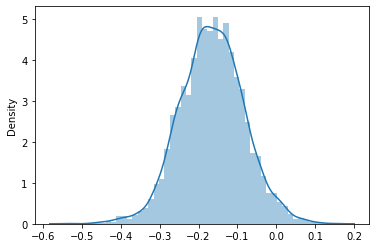

In [90]:
diff = traceM['b'][:,1] - traceM['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')

In [92]:
# same for K
df_longKR = df_longK.reset_index(drop=True) # need to reset the indices
df_longKR
traceK = runBayes(df_longKR)

     scr_id  groupIdx    variable     value
0    KPE008         1  amg_vmPFC1 -0.009363
1   KPE1223         1  amg_vmPFC1  0.766076
2   KPE1293         1  amg_vmPFC1  0.565582
3   KPE1307         1  amg_vmPFC1  0.620574
4   KPE1322         1  amg_vmPFC1  0.430485
5   KPE1339         1  amg_vmPFC1  0.663318
6   KPE1343         1  amg_vmPFC1  0.697343
7   KPE1387         1  amg_vmPFC1  0.202980
8   KPE1419         1  amg_vmPFC1  0.677530
9   KPE1464         1  amg_vmPFC1  0.623610
10  KPE1499         1  amg_vmPFC1  0.565721
11  KPE1573         1  amg_vmPFC1  0.754208
12  KPE1587         1  amg_vmPFC1  0.586879
13   KPE008         1  amg_vmPFC2  0.365332
14  KPE1223         1  amg_vmPFC2  0.310339
15  KPE1293         1  amg_vmPFC2  0.675950
16  KPE1307         1  amg_vmPFC2  0.004965
17  KPE1322         1  amg_vmPFC2  0.533506
18  KPE1339         1  amg_vmPFC2  0.381881
19  KPE1343         1  amg_vmPFC2  0.458034
20  KPE1387         1  amg_vmPFC2  0.637901
21  KPE1419         1  amg_vmPFC

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.
The number of effective samples is smaller than 25% for some parameters.


0.02375


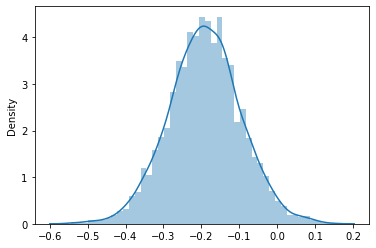

In [94]:
diff = traceK['b'][:,2] - traceK['b'][:,0]
sns.distplot(diff)
print(f'{sum(diff>0)/len(diff)}')